In [1]:
import os
import sys
import tempfile
import webbrowser

srcpath = os.path.realpath('SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from teproteus_functions_v3 import connect
from teproteus_functions_v3 import disconnect
from teproteus_functions_v3 import set_lib_dir_path
from teproteus_functions_v3 import get_cpatured_header
from teproteus_functions_v3 import gauss_env
from teproteus_functions_v3 import iq_kernel
from teproteus_functions_v3 import pack_kernel_data
from tevisainst import TEVisaInst

# matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import signal
from scipy.signal import fftconvolve
import math

In [8]:
def interleave(wfm_i, wfm_q) :
    assert (len(wfm_i) == len(wfm_q))
    half_len = len(wfm_i)
    a = np.empty(2 * half_len)
    b = a.view()
    b.shape = (half_len, 2)
    b[:, 0] = wfm_i
    b[:, 1] = wfm_q
    return a

# Proteus Parameters
max_dac         = 65535
half_dac        = np.round(max_dac/2)
data_type       = np.uint16
chNum           = 1                                                                  # No. of Channels
granual         = 64                                                                 # Granularity of the DAC    
interpol        = 8                                                                  # Interpolation Factor, 1 = NONE, 2 = X2, 4 = X4, 8 = X8

# Build two AWG segment one for I and one for Q
mod_freq        = 20000000
segLen          = 2**14
req_sb          = 'LSB'                                                              # Side Band Selection, LSB = Lower Side Band, USB = Upper Side Band

# NCO Setting Parameters
cwFreq          = 1800.0E+6                                                          # Center Frequency per Channel
phase           = 0                                                                 # Phase of signal
apply6db        = 1                                                                  # Enable 6 dB Gain

# AWG Setting Parameters
samplingRate    = 9.0E+9                                                             # Sampling Rate
OUTPV           = 0.50                                                               # Channel O/P Voltage


In [9]:
# Connect to instrument

pid = os.getpid()
print('process id {0}'.format(pid))

proteus_addr = 'TCPIP::169.254.103.249::5025::SOCKET'

try:
    proteus = TEVisaInst(proteus_addr)
except TEVisaInst.Error as ex1:
    print('Could not connect to %s', proteus_addr)
    sys.exit()

proteus.default_paranoia_level = 2 # Set the default paranoia-level (0, 1 or 2)

# Clear reset the instrument
proteus.send_scpi_cmd('*CLS; *RST')

# Instrument's identification and slot details
resp = proteus.send_scpi_query(":SYST:ERR?")  #To check system error-list
print(resp)
resp = proteus.send_scpi_query('*IDN?')
print('Connected to: ' + resp)

# Get the model:
model_name = proteus.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get number of channels
num_channels = int(proteus.send_scpi_query(':INST:CHAN? MAX'))
print('Number of channels: {}'.format(num_channels))


process id 15168
0, no error
Connected to: Tabor Electronics,P9484D,000002210902,1.240.35 --slot#: 5, 
Model: P9484D 
Number of channels: 4


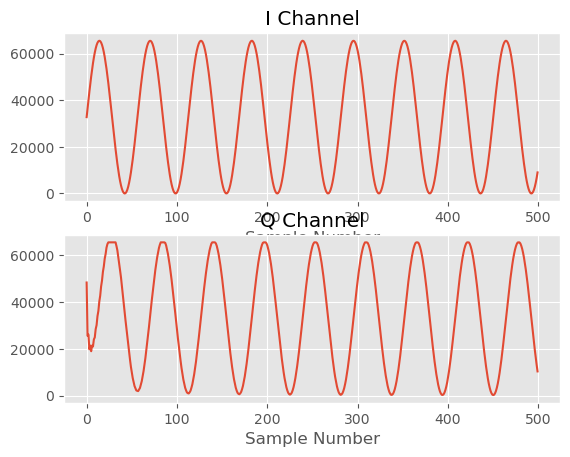

In [10]:
# download it to segment 1 of channel 1

t       = np.zeros(segLen)
waveI   = np.zeros(segLen)
waveQ   = np.zeros(segLen)

# Build waveform (cosine wave)
for i in range(0, segLen):
    t[i] = (i/(samplingRate/interpol))

# In SSB Modulation, 
# I = Cos(X), generates Lower Sideband 
# I = Sin(X), generates Upper Sideband

waveI = np.sin(2*np.pi*mod_freq*t)

# Taking the Hilbert transform of the I signal to get the Q signal
waveQ = np.imag(signal.hilbert(waveI))

waveI = (waveI + 1.0) * half_dac
waveI = np.round(waveI)
waveI = np.clip(waveI, 0, max_dac)
waveI = waveI.astype(data_type)

waveQ = (waveQ + 1.0) * half_dac
waveQ = np.round(waveQ)
waveQ = np.clip(waveQ, 0, max_dac)
waveQ = waveQ.astype(data_type)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(waveI[0:500])
plt.title('I Channel')
plt.xlabel('Sample Number')
plt.subplot(2, 1, 2)
plt.plot(waveQ[0:500])
plt.title('Q Channel')
plt.xlabel('Sample Number')
plt.show()

In [11]:
# Download the waveform to the selected segment and channel
proteus.send_scpi_cmd(':INST:ACT:SEL 1') # Select Master module

if req_sb == 'USB':

    # Play selected segment in selected channel and set amplitude

    proteus.send_scpi_cmd(':INST:CHAN 1')
    proteus.send_scpi_cmd(':TRAC:DEF 1, {0}' .format(len(waveI)))
    proteus.send_scpi_cmd(':TRAC:SEL 1')

    # download the waveform to the selected segment
    proteus.write_binary_data(':TRAC:DATA', waveI)
    resp = proteus.send_scpi_query(':SYST:ERR?')
    print(resp)

    proteus.send_scpi_cmd(':INST:CHAN 2')
    proteus.send_scpi_cmd(':TRAC:DEF 2, {0}' .format(len(waveQ)))
    proteus.send_scpi_cmd(':TRAC:SEL 2')

    # download the waveform to the selected segment
    proteus.write_binary_data(':TRAC:DATA', waveQ)
    resp = proteus.send_scpi_query(':SYST:ERR?')
    print(resp)

else:
    # Play selected segment in selected channel and set amplitude

    proteus.send_scpi_cmd(':INST:CHAN 1')
    proteus.send_scpi_cmd(':TRAC:DEF 1, {0}' .format(len(waveQ)))
    proteus.send_scpi_cmd(':TRAC:SEL 1')

    # download the waveform to the selected segment
    proteus.write_binary_data(':TRAC:DATA', waveQ)
    resp = proteus.send_scpi_query(':SYST:ERR?')
    print(resp)

    proteus.send_scpi_cmd(':INST:CHAN 2')
    proteus.send_scpi_cmd(':TRAC:DEF 2, {0}' .format(len(waveI)))
    proteus.send_scpi_cmd(':TRAC:SEL 2')

    # download the waveform to the selected segment
    proteus.write_binary_data(':TRAC:DATA', waveI)
    resp = proteus.send_scpi_query(':SYST:ERR?')
    print(resp)


0, no error
0, no error


In [ ]:
# NCO Frequency calculation
ncoFreq = cwFreq 

while (ncoFreq > samplingRate):
    ncoFreq = ncoFreq - samplingRate

proteus.send_scpi_cmd(':INST:ACT:SEL 1')  # Select Master module
res = proteus.send_scpi_query(':INST:ACT:SEL?')
print('Reseting Instrument: '+ res)
# Play selected segment in selected channel and set amplitude

# Select channel 1 in a sequence
proteus.send_scpi_cmd(':INST:CHAN {0}'.format(1))

phs1 = 0

# Set the Baseband Sampling Rate
proteus.send_scpi_cmd(':SOUR:FREQ:RAST {0}'.format(2.5E+9))

# Set DUC mode for the Channel
proteus.send_scpi_cmd(':SOUR:MODE DUC')

# Set the Interpolation Factor
if interpol == 1:
    proteus.send_scpi_cmd(':SOUR:INT NONE')
else:
    proteus.send_scpi_cmd(':SOUR:INT X{0}' .format(interpol))
       
# Set the IQM Mode
proteus.send_scpi_cmd(':SOUR:IQM HALF')

# Set NCO1 Frequency for the current channel
proteus.send_scpi_cmd(':NCO:CFR1 {0}'.format(ncoFreq)) # CHANGE to CFR1

# Set NCO1 Phase for the current channel
proteus.send_scpi_cmd(':NCO:PHAS1 {0}'.format(phs1)) #CHANGE to PHAS1

# Apply amplitude boost to NCO
if apply6db == 1:
    proteus.send_scpi_cmd(':NCO:SIXD1 ON')
else:
    proteus.send_scpi_cmd(':NCO:SIXD1 OFF')

# Play the Segmennt 1 for the current channel 1
proteus.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM {0}' .format(1)) # Select segment mode

# Set the DAC Sampling Rate
proteus.send_scpi_cmd(':SOUR:FREQ:RAST {0}'.format(samplingRate)) # Set sampling rate

# Set ouput voltage
proteus.send_scpi_cmd(':SOUR:VOLT {0}'.format(OUTPV))

# Switch on output
proteus.send_scpi_cmd(':OUTP ON')

# Select channel 2 in a sequence
proteus.send_scpi_cmd(':INST:CHAN {0}'.format(2))

phs2 = phase

# Set the Baseband Sampling Rate
proteus.send_scpi_cmd(':SOUR:FREQ:RAST {0}'.format(2.5E+9))

# Set DUC mode for the Channel
proteus.send_scpi_cmd(':SOUR:MODE DUC')

# Set the Interpolation Factor
if interpol == 1:
    proteus.send_scpi_cmd(':SOUR:INT NONE')
else:
    proteus.send_scpi_cmd(':SOUR:INT X{0}' .format(interpol))
       
# Set the IQM Mode
proteus.send_scpi_cmd(':SOUR:IQM HALF')

# Set NCO1 Frequency for the current channel
proteus.send_scpi_cmd(':NCO:CFR1 {0}'.format(ncoFreq)) # CHANGE to CFR1

# Set NCO1 Phase for the current channel
proteus.send_scpi_cmd(':NCO:PHAS1 {0}'.format(phs2)) #CHANGE to PHAS1

# Apply amplitude boost to NCO
if apply6db == 1:
    proteus.send_scpi_cmd(':NCO:SIXD1 ON')
else:
    proteus.send_scpi_cmd(':NCO:SIXD1 OFF')

# Play the Segmennt 2 for the current channel 2
proteus.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM {0}' .format(2)) # Select segment mode

# Set the DAC Sampling Rate
proteus.send_scpi_cmd(':SOUR:FREQ:RAST {0}'.format(samplingRate)) # Set sampling rate

# Set ouput voltage
proteus.send_scpi_cmd(':SOUR:VOLT {0}'.format(OUTPV))

# Switch on output
proteus.send_scpi_cmd(':OUTP ON')

Reseting Instrument: 1


0

In [7]:
disconnect()